In [20]:
# import packages 
import awkward as ak
import pandas as pd
import numpy as np
import re
import shutil
import os


# 1) Import DMRs for all comparisons 

In [21]:
# Dictionary to store dmr_subset with their names
dmr_subsets = {}

# List of input files
input_files = ['6_DMRsCG/1_NvsA/1_NvsA.txt', '6_DMRsCG/2_NvsR/2_NvsR.txt', '6_DMRsCG/3_AvsR/3_AvsR.txt']

# Process each input file
for input_file in input_files:
    # Reading data from the input file and converting it to an awkward array
    array = []
    with open(input_file, 'r') as file:
        for line in file:
            columns = line.strip().split('\t')  # Split the line into columns
            array.append(columns)

    df = ak.from_iter(array)

    # Extract column 1, 2, 3
    dmr_subset = df[:, [0, 1, 2]]

    # Convert to pandas dataframe
    dmr_subset = pd.DataFrame(dmr_subset)
    dmr_subset.rename(columns={0: 'chr', 1: 'start', 2: 'end'}, inplace=True)

    # Convert to int
    dmr_subset['start'] = dmr_subset['start'].astype(int)
    dmr_subset['end'] = dmr_subset['end'].astype(int)
    dmr_subset['chr'] = dmr_subset['chr'].astype(str)

    # Assign the name to dmr_subset
    subset_name = 'dmr_subset_' + os.path.basename(os.path.dirname(input_file))
    dmr_subsets[subset_name] = dmr_subset


In [22]:
dmr_subset

,chr,start,end
0,ccar_ua02,27087438,27087561
1,ccar_ua05,9401931,9401987
2,ccar_ua05,27874305,27874422
3,ccar_ua09,11672933,11673140
4,ccar_ua09,32976439,32976654
5,ccar_ua13,1927577,1927998
6,ccar_ua13,1927577,1927998
7,ccar_ua14,1067421,1067644
8,ccar_ua18,3682678,3682796
9,ccar_ua18,3682678,3682796


# 2) Import gene annotation

In [23]:
# import ccar_annotation.gtf as pd df 
import pandas as pd 

annotation = pd.read_csv('7_match_dmr_to_gene/ccar_annotation.gtf', sep='\t', skiprows=1, header=None)
# renaming the header of the annotation file
annotation = annotation.rename({0: 'seqname',
                                1: 'source',
                                2: 'feature',
                                3: 'start',
                                4: 'stop',
                                5: 'score',
                                6: 'strand',
                                7: 'frame',
                                8: 'attribute'}, axis=1)

    
# define a function to extract the geneid
def extract_gene_id(attributes):
    # Using a regular expression to match and extract the desired part
    match = re.search(r'gene_id "([^"]+)"', attributes)
    if match:
        return match.group(1)
    else:
        return 0 # Return 0 if there is no match
    
# filtering the column feature for transcritps
annotation = annotation[annotation['feature'] == 'transcript']
# Apply the function to the "attributes" column and create a new column with the extracted gene ids
annotation['gene_id'] = annotation['attribute'].apply(extract_gene_id)

# 3) Add 2000 bp to start and stop of gene id's to simulate UTRs (untranslated regions) 

In [24]:
# extract seqname , start and stop column 
anno_subset = annotation[['seqname', 'start', 'stop', 'gene_id']]
# create new column called "start_2000"
anno_subset['start_2000'] = anno_subset['start'] - 2000
# check if any value is negative and replace it with 0
anno_subset['start_2000'] = np.where(anno_subset['start_2000'] < 0, 0, anno_subset['start_2000'])
# create new column called "stop_2000"
anno_subset['stop_2000'] = anno_subset['stop'] + 2000

/tmp/ipykernel_4395/1375675161.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_subset['start_2000'] = anno_subset['start'] - 2000
/tmp/ipykernel_4395/1375675161.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_subset['start_2000'] = np.where(anno_subset['start_2000'] < 0, 0, anno_subset['start_2000'])
/tmp/ipykernel_4395/1375675161.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

# 4) Identify if DMR is within gene borders --> append geneid to list 

In [25]:
# Dictionary to store the result_transcript_ids with their names
result_transcript_ids_dict = {}

# Check conditions and extract transcript_id for each dmr_subset
for subset_name, dmr_subset in dmr_subsets.items():
    result_transcript_ids = []
    comparison = subset_name.split('_')[-1]  # Get the comparison type (NvsA = 1, NvsR = 2, or AvsR = 3)
    for index, row in dmr_subset.iterrows():
        chr_val = row['chr']
        start_val = row['start']
        end_val = row['end']
        relevant_anno_subset = anno_subset[(anno_subset['seqname'] == chr_val) & (anno_subset['start_2000'] <= start_val) & (anno_subset['stop_2000'] >= end_val)]
        
        # Append transcript_id to the result_transcript_ids list
        if not relevant_anno_subset.empty:
            result_transcript_ids.extend(relevant_anno_subset['gene_id'].tolist())
    
    # Assign the result_transcript_ids to a specific name with the comparison type
    result_name = f"{comparison}"
    result_transcript_ids_dict[result_name] = result_transcript_ids


In [26]:
# check how many dmrs are within gene borders. 
print('NvsA:', len(set(result_transcript_ids_dict['NvsA'])))
print('NvsR:', len(set(result_transcript_ids_dict['NvsR'])))
print('AvsR:', len(set(result_transcript_ids_dict['AvsR'])))

NvsA: 35
NvsR: 58
AvsR: 25


In [27]:
# export the set(result_transcript_ids_dict['XvsX']) to a file
with open('7_match_dmr_to_gene/NvsA_gene_ids.txt', 'w') as file:
    for item in set(result_transcript_ids_dict['NvsA']):
        file.write("%s\n" % item)
with open('7_match_dmr_to_gene/NvsR_gene_ids.txt', 'w') as file:
    for item in set(result_transcript_ids_dict['NvsR']):
        file.write("%s\n" % item)
with open('7_match_dmr_to_gene/AvsR_gene_ids.txt', 'w') as file:
    for item in set(result_transcript_ids_dict['AvsR']):
        file.write("%s\n" % item)
    

# 5) Correlate to DEGs

In [28]:
# import deg data from RNA pipeline 
deg_NvsA = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/deg_na.txt', sep=',')
deg_NvsR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/deg_nr.txt', sep=',')	
deg_AvsR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/deg_ar.txt', sep=',')

In [29]:
deg_na = set(deg_NvsA['Unnamed: 0'])
deg_nr = set(deg_NvsR['Unnamed: 0'])
deg_ar = set(deg_AvsR['Unnamed: 0'])

print(len(deg_na))
print(len(deg_nr))
print(len(deg_ar))

529
210
232


In [30]:
len(deg_na.intersection(set(result_transcript_ids_dict['NvsA'])))

1

In [31]:
len(deg_nr.intersection(set(result_transcript_ids_dict['NvsR'])))

1

In [32]:
len(deg_ar.intersection(set(result_transcript_ids_dict['AvsR'])))

0

# Venn diagram 

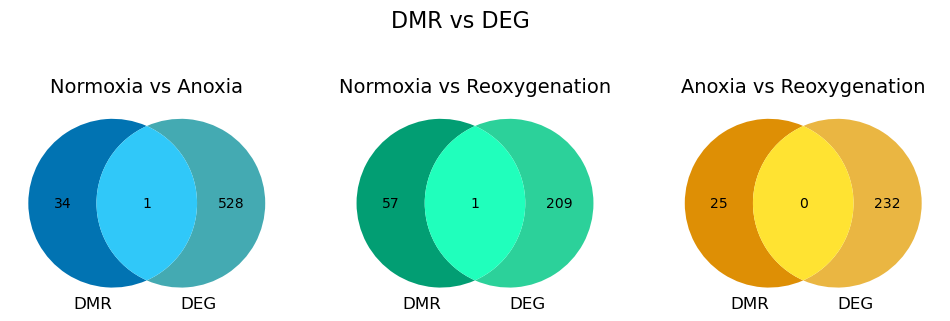

In [36]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted

# Sample data for Venn diagrams
# DMS data
DMR_na = set(result_transcript_ids_dict['NvsA'])
DMR_nr = set(result_transcript_ids_dict['NvsR'])
DMR_ar = set(result_transcript_ids_dict['AvsR'])
# DEG data 
DEG_na = deg_na
DEG_nr = deg_nr
DEG_ar = deg_ar

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot Venn diagrams in each subplot
venn2_unweighted([DMR_na, DEG_na], set_labels=('DMR', 'DEG'), ax=axes[0], alpha=1, set_colors=('#0173b2','#44AAB2'), normalize_to=1.0)
venn2_unweighted([DMR_nr, DEG_nr], set_labels=('DMR', 'DEG'), ax=axes[1], alpha=1, set_colors=('#029e73','#2CD19A'), normalize_to=1.0)
venn2_unweighted([DMR_ar, DEG_ar], set_labels=('DMR', 'DEG'), ax=axes[2], alpha=1, set_colors=('#de8f05','#EAB642'), normalize_to=1.0)


# add titles to the subplots
axes[0].set_title('Normoxia vs Anoxia', fontsize=14)
axes[1].set_title('Normoxia vs Reoxygenation', fontsize=14)
axes[2].set_title('Anoxia vs Reoxygenation', fontsize=14)

# Add titles in center 
fig.suptitle('DMR vs DEG', fontsize=16)

# Save the figure as a high-quality image (e.g., PNG or PDF)
plt.savefig('7_match_dmr_to_gene/DMR_vs_DEG_venn.png', dpi=300, bbox_inches='tight')
plt.savefig('7_match_dmr_to_gene/DMR_vs_DEG_venn.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig('7_match_dmr_to_gene/DMR_vs_DEG_venn.tiff', format='tiff', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
